# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import thor

thor.setupOorb()
config = thor.Config()

In [3]:
DATABASE = "../data/msst_survey.db"
con = sql.connect(DATABASE)

## Config

In [4]:
from thor import Config

## Plotting Code

In [5]:
from thor.plotting import plotProjections
from thor.plotting import plotProjections3D
from thor.plotting import plotObservations
from thor.plotting import plotObservations3D
from thor.plotting import plotBinnedContour
from thor.plotting import plotScatterContour
from thor.plotting import plotCell

## Classes 

In [6]:
from thor import Cell
from thor import TestParticle

## Functions

In [7]:
from thor import findAverageObject
from thor import findExposureTimes
from thor import buildCellForVisit
from thor import rangeAndShift
from thor import clusterAndLink
from thor import analyzeClusters
from thor import runRangeAndShiftOnVisit
from thor import runClusterAndLinkOnVisit

# Load Data

In [8]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations""", con)
noise = pd.read_sql("""SELECT * FROM noise_100""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

In [9]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [10]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [11]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]

In [12]:
neos = orbits[orbits["a_au"] <= 1.3]["designation"].values

## Range and Shift

In [22]:
projected_obs, average_obj = runRangeAndShiftOnVisit(observations, 
                        1, 
                        0,
                        0,
                        useAverageObject=True,
                        searchArea=10,
                        cellArea=10)

THOR: runRangeAndShiftOnVisit
-------------------------
Running Thor on visit 1...
Search cell area: 10 
Search cell shape: square 
Cell area: 10 
Cell shape: square 

THOR: findAverageObject
-------------------------
p3143 is the most average object.
-------------------------

THOR: rangeAndShift
-------------------------
Running range and shift...
Assuming r = 2.7617290181 AU
Assuming v = [-0.00964426 -0.00379003  0.00017245] AU per day
Preparing rotation matrices...
Convering to ecliptic coordinates...
Calculating object to observer unit vector...
Calculating object to observer distance assuming r = 2.7617290181 AU...
Calculating object to observer position vector...
Calculating barycentic object position vector...
Calculating vector normal to plane of orbit...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.

THOR: findExposureTimes
-------------------------
Generating particle ephemeris for the middle of every night.
Fi

## Cluster and Link

In [24]:
allClusters, clusterMembers = clusterAndLink(
        projected_obs,
        eps=0.005, 
        minSamples=5, 
        vxRange=[-0.1, 0.1], 
        vyRange=[-0.1, 0.1],
        vxBins=100,
        vyBins=100, 
        threads=5)

THOR: clusterAndLink
-------------------------
Running velocity space clustering...
X velocity range: [-0.1, 0.1]
X velocity bins: 100
Y velocity range: [-0.1, 0.1]
Y velocity bins: 100
User defined x velocity values: False
User defined y velocity values: False
Velocity grid size: 10000
Max sample distance: 0.005
Minimum samples: 5
Using 5 threads...
Done. Completed in 603.3557448387146 seconds.

Restructuring clusters...
Done. Completed in 0.3429298400878906 seconds.

Found 8128 clusters.
Total time in seconds: 603.6990118026733
-------------------------



## Analysis

In [25]:
allClusters, clusterMembers, allObjects, summary = analyzeClusters(
    projected_obs,
    allClusters, 
    clusterMembers, 
    minSamples=5, 
    partialThreshold=5)

THOR: analyzeClusters
-------------------------
Analyzing observations...
Object observations: 21840
Noise observations: 11822
Observation contamination (%): 35.11971956508823
Unique objects: 3055
Unique objects with at least 5 detections: 1856
Unique objects with at least 500% of 5 detections: 0

Analyzing clusters...
Pure clusters: 1480
Partial clusters: 0
Duplicate visit clusters: 3806
False clusters: 6648
Total clusters: 8128
Cluster contamination (%): 81.79133858267717
Unique linked objects: 834
Unique missed objects: 1022
Completeness (%): 44.935344827586206
Done.
Total time in seconds: 0.350017786026001
-------------------------



In [27]:
visitId = 1
columnMapping = Config.columnMapping
avg_obj = average_obj[columnMapping["name"]].values[0]
o = orbits[orbits[columnMapping["name"]] == avg_obj]
    
found = orbits[orbits[columnMapping["name"]].isin(allObjects[allObjects["found"] == 1][columnMapping["name"]])]
missed = orbits[orbits[columnMapping["name"]].isin((allObjects[(allObjects["found"] == 0) & (allObjects["findable"] == 1)][columnMapping["name"]]))]

Text(0.5,1,'Missed Orbits\nVisit: 1, Object: p3143')

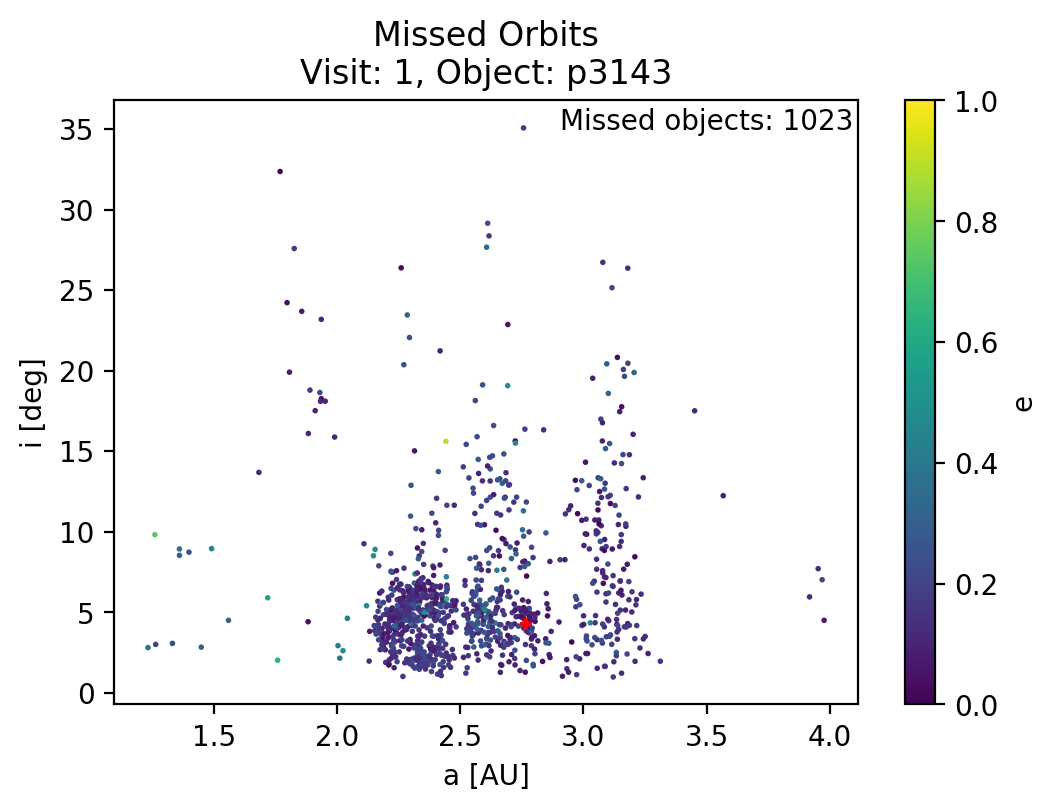

In [28]:
fig, ax = plotScatterContour(missed, 
                             columnMapping["a_au"],
                             columnMapping["i_deg"],
                             columnMapping["e"],
                             plotCounts=False, 
                             logCounts=True, 
                             countLevels=4, 
                             mask=None,
                             xLabel="a [AU]",
                             yLabel="i [deg]",
                             zLabel="e",
                             scatterKwargs={"s": 1, "vmin": 0, "vmax": 1})
ax.text(ax.get_xlim()[-1] - 0.40 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1] - 0.05 * ax.get_ylim()[1], "Missed objects: {}".format(len(missed)))
ax.scatter(o["a_au"].values, o["i_deg"].values, c="r", s=20, marker="+")
ax.set_title("Missed Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))


Text(2.60683,27.5298,'Found objects: 837')

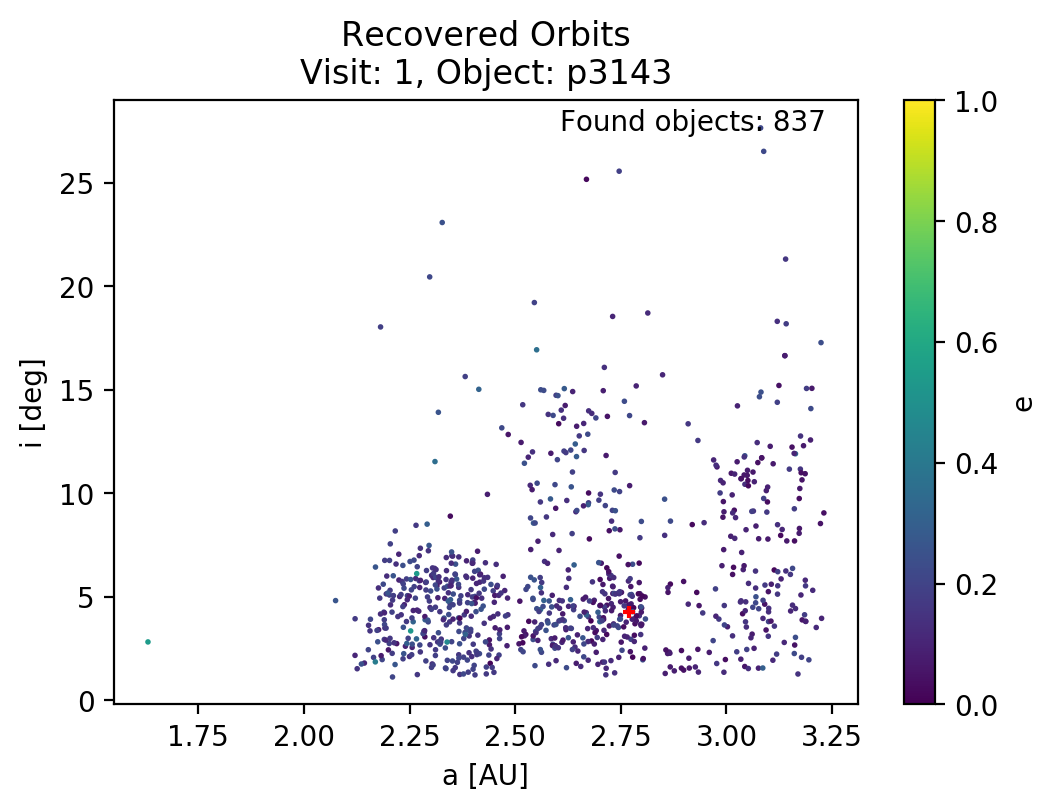

In [29]:
fig, ax = plotScatterContour(found, 
                                 columnMapping["a_au"],
                                 columnMapping["i_deg"],
                                 columnMapping["e"],
                                 plotCounts=False, 
                                 logCounts=True, 
                                 countLevels=4, 
                                 mask=None,
                                 xLabel="a [AU]",
                                 yLabel="i [deg]",
                                 zLabel="e",
                                 scatterKwargs={"s": 1, "vmin": 0, "vmax": 1})        
ax.scatter(o["a_au"].values, o["i_deg"].values, c="r", s=20, marker="+")
ax.set_title("Recovered Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))
ax.text(ax.get_xlim()[-1] - 0.40 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1] - 0.05 * ax.get_ylim()[1], "Found objects: {}".format(len(found)))


In [30]:
found_obs = projected_obs[projected_obs[columnMapping["name"]].isin(allObjects[allObjects["found"] == 1][columnMapping["name"]])]
missed_obs = projected_obs[projected_obs[columnMapping["name"]].isin((allObjects[(allObjects["found"] == 0) & (allObjects["findable"] == 1)][columnMapping["name"]]))]
obs = projected_obs[projected_obs[columnMapping["name"]] == avg_obj]

Text(0.5,1,'Missed Orbits\nVisit: 1, Object: p3143')

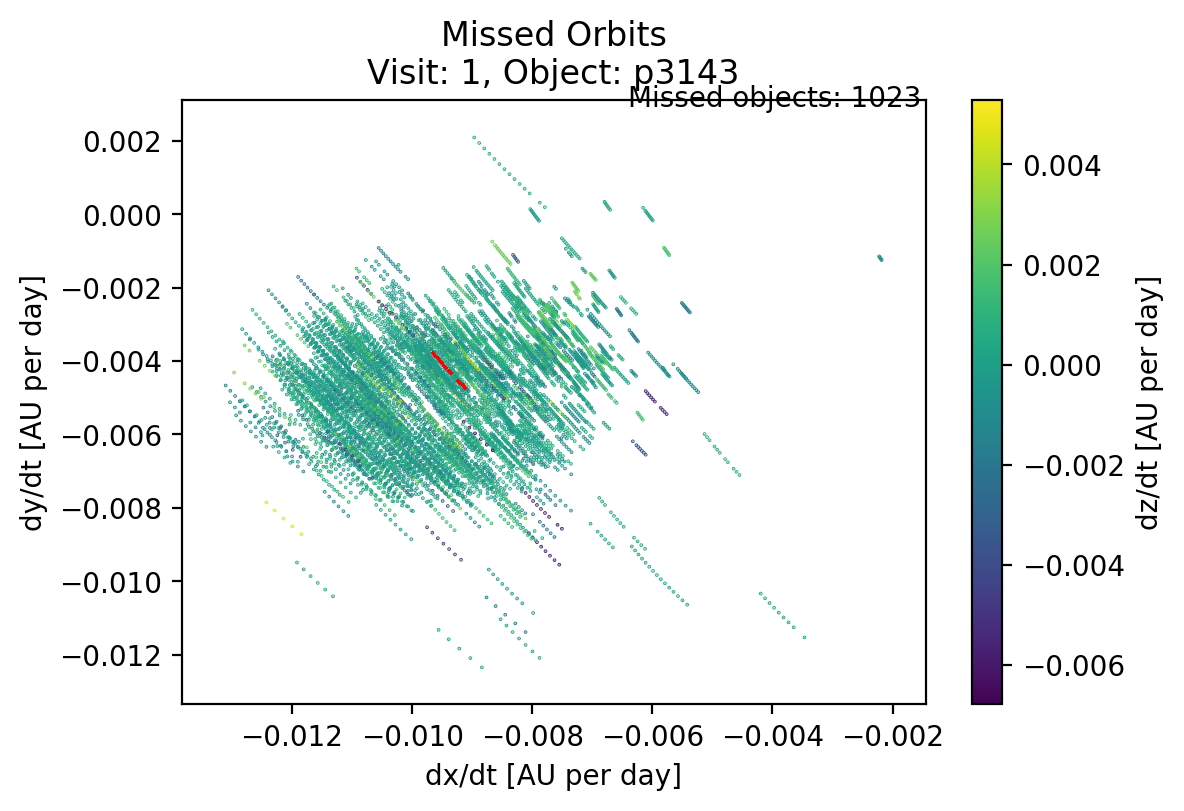

In [31]:
fig, ax = plotScatterContour(missed_obs, 
                                 columnMapping["obj_dx/dt_au_p_day"], 
                                 columnMapping["obj_dy/dt_au_p_day"], 
                                 columnMapping["obj_dz/dt_au_p_day"],
                                 countLevels=4, 
                                 xLabel="dx/dt [AU per day]",
                                 yLabel="dy/dt [AU per day]",
                                 zLabel="dz/dt [AU per day]")
   
ax.text(ax.get_xlim()[-1] - 0.40 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1] - 0.05 * ax.get_ylim()[1], "Missed objects: {}".format(len(missed)))
ax.scatter(*obs[[columnMapping["obj_dx/dt_au_p_day"], columnMapping["obj_dy/dt_au_p_day"]]].values.T, c="r", s=1, marker="+")
ax.set_title("Missed Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))

Text(-0.0082271,0.000964367,'Found objects: 1023')

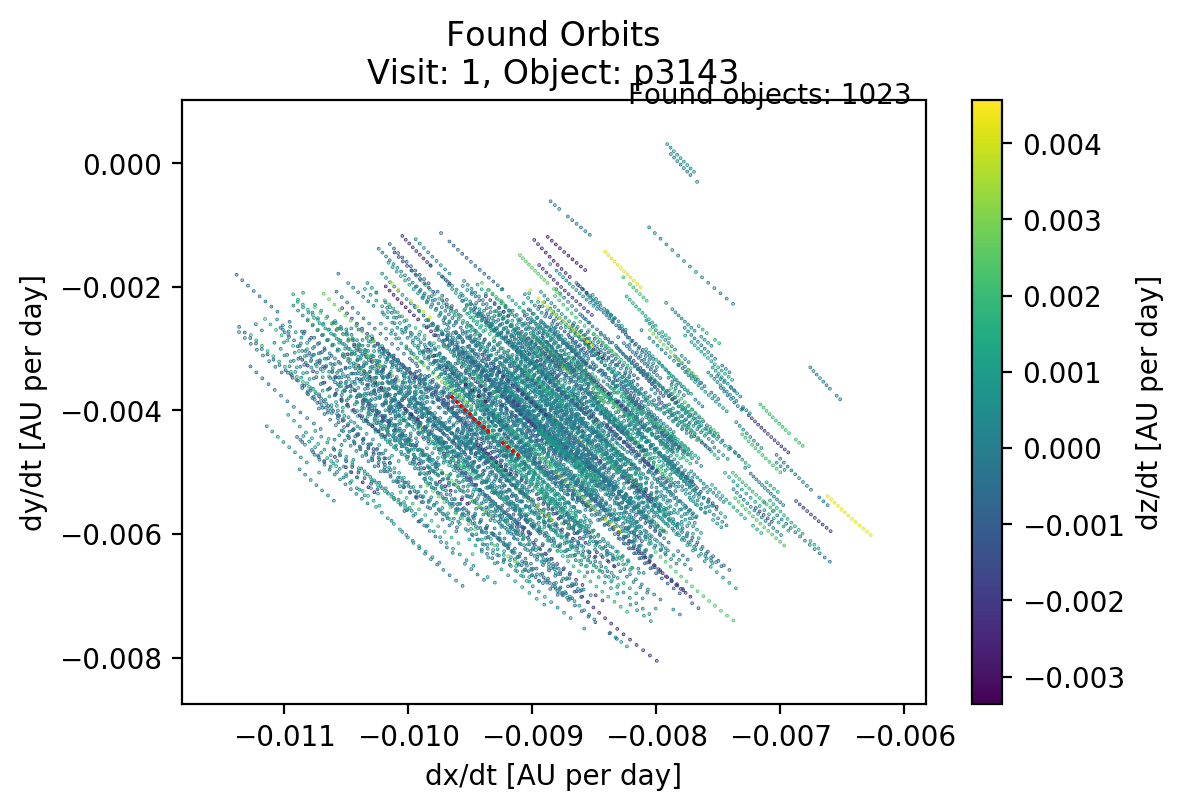

In [32]:
fig, ax = plotScatterContour(found_obs, 
                                 columnMapping["obj_dx/dt_au_p_day"], 
                                 columnMapping["obj_dy/dt_au_p_day"], 
                                 columnMapping["obj_dz/dt_au_p_day"],
                                 countLevels=4, 
                                 xLabel="dx/dt [AU per day]",
                                 yLabel="dy/dt [AU per day]",
                                 zLabel="dz/dt [AU per day]")
   
ax.scatter(*obs[[columnMapping["obj_dx/dt_au_p_day"], columnMapping["obj_dy/dt_au_p_day"]]].values.T, c="r", s=1, marker="+")
ax.set_title("Found Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))
ax.text(ax.get_xlim()[-1] - 0.40 * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[1] - 0.05 * ax.get_ylim()[1], "Found objects: {}".format(len(missed)))

## Additional Plots

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["designation"].isin(allObjects[allObjects["found"] == 1]["designation"].values)],
    colorByObject=False)

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["designation"].isin(allObjects[(allObjects["findable"] == 1) & (allObjects["found"] == 0)]["designation"].values)],
    colorByObject=True)

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["designation"].isin(allObjects[(allObjects["findable"] == 1) & (allObjects["found"] == 0)]["designation"].values)],
    colorByObject=True)

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin(allClusters[allClusters["pure"] == 1]["cluster_id"].values)]["obs_id"])],
    colorByObject=False)

In [ ]:
fig = plotProjections3D(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin(allClusters[allClusters["pure"] == 1]["cluster_id"].values)]["obs_id"])],
    colorByObject=False)

In [ ]:
fig = plotProjections3D(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin([allClusters[allClusters["num_visits"] != allClusters["num_obs"]]["cluster_id"].values[0]])]["obs_id"])],
    colorByObject=False)

In [ ]:
fig = plotProjections3D(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin(allClusters[allClusters["pure"] == 1]["cluster_id"].values)]["obs_id"])],
    colorByObject=False)